# Download,  Parse and Interrogate Apple Health Export Data

The first part of this program is all about getting the Apple Health export and putting it into an analyzable format. At that point it can be analysed anywhere. The second part of this program is concerned with using SAS Scripting Wrapper for Analytics Transfer (SWAT) Python library to transfer the data to SAS Viya, and analyze it there. The SWAT package provides native python language access to the SAS Viya codebase.

> https://github.com/sassoftware/python-swat

This file was created from a desire to get my hands on data collected by Apple Health, notably heart rate information collected by Apple Watch. For this to work, this file needs to be in a location accessible to Python code. A little bit of searching told me that iCloud file access is problematic and that there were already a number of ways of doing this with the Google API if the file was saved to Google Drive. I chose PyDrive. So for the end to end program to work with little user intervention, you will need to sign up for Google Drive, set up an application in the Google API and install Google Drive app to your iPhone. 

This may sound involved, and it is not necessary if you simply email the export file to yourself and copy it to a filesystem that Python can see. If you choose to do that, all of the Google Drive portion can be removed. I like the Google Drive process though as it enables a minimal manual work scenario.

This version requires the user to grant Google access, requiring some additional clicks, but it is not too much. I think it is possible to automate this to run without user intervention as well using security files.

The first step to enabling this process is exporting the data from Apple Health. As of this writing, open Apple Health and click on your user icon or photo. Near the bottom of the next page in the app will be a button or link called Export Health Data. Clicking on this will generate a xml file, zipped up. THe next dialog will ask you where you want to save it. Options are to email, save to iCloud, message etc...  Select Google Drive. Google Drive allows multiple  files with the same name and this is accounted for by this program.

In [517]:
import xml.etree.ElementTree as et
import pandas as pd
import numpy as np
from datetime import *
import matplotlib.pyplot as plt
import re 
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 8

##  Authenticate with Google 
This will open a browser to let you beging the process of authentication with an existing Google Drive account. This process will be separate from Python. For this to work, you will need to set up a Other Authentication OAuth credential at https://console.developers.google.com/apis/credentials, save the secret file in your root directory and a few other things that are detailed at https://pythonhosted.org/PyDrive/. The PyDrive instructions also show you how to set up your Google application. There are other methods for accessing the Google API from python, but this one seems pretty nice. 
The first time through the process, regular sign in and two factor authentication is required (if you require two factor auth) but after that it is just a process of telling Google that it is ok for your Google application to access Drive.

In [518]:
# Authenticate into Google Drive
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() 

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=643038572377-3l8prnqdfm6o5ualucljs78l9vao60qb.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&response_type=code&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline

Authentication successful.


### Download the most recent Apple Health export file
Now that we are authenticated into Google Drive, use PyDrive to access the API and get to files stored.

Google Drive allows multiple files with the same name, but it indexes them with the ID to keep them separate.
In this block, we make one pass of the file list where the file name is called export.zip, and save the row that corresponds with the most recent date. We will use that  file id later to download the correct file that corresponds  with the most recent date. Apple Health export names the file export.zip, and at the time this was written, there is no other option.

In [519]:
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)

file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

# Step through the file list and find the most current export.zip file id, then use 
#      that later to download the file to the local machine.
# This may look a little old school, but these file lists will never be massive and 
#     it is readable and easy one pass way to get the most current file using the 
#     least (or low) amount of resouces
selection_dt = datetime.strptime("2000-01-01T01:01:01.001Z","%Y-%m-%dT%H:%M:%S.%fZ")
print("Matching Files")
for file1 in file_list: 
    if re.search("^export.zip",file1['title']):
        dt = datetime.strptime(file1['createdDate'],"%Y-%m-%dT%H:%M:%S.%fZ")
        if dt > selection_dt:
            selection_id = file1['id']
            selection_dt = dt
        print('    title: %s, id: %s createDate: %s' % (file1['title'], file1['id'], file1['createdDate']))

Matching Files
    title: export.zip, id: 0B_EXRCwLorf3bk5jQ2NQcXBTLW8 createDate: 2017-06-22T19:06:11.516Z
    title: export.zip, id: 0B_EXRCwLorf3WXJRcldqemJxazA createDate: 2017-06-21T16:09:20.574Z
    title: export.zip, id: 0B_EXRCwLorf3djB2U2VQcDRiNEk createDate: 2017-06-20T22:03:15.429Z
    title: export.zip, id: 0B_EXRCwLorf3eXNsUjFKWmZ1ck0 createDate: 2017-06-20T16:48:00.878Z
    title: export.zip, id: 0B_EXRCwLorf3UHRCT0JuaGVrT1E createDate: 2017-06-19T15:56:55.500Z
    title: export.zip, id: 0B_EXRCwLorf3NV9Jc0g2cXJReE0 createDate: 2017-06-18T22:08:38.538Z
    title: export.zip, id: 0B_EXRCwLorf3SHpxNmg5NWd0anM createDate: 2017-06-18T11:15:25.960Z
    title: export.zip, id: 0B_EXRCwLorf3d0h5TjNQeGlSakU createDate: 2017-06-17T10:55:34.833Z
    title: export.zip, id: 0B_EXRCwLorf3YU9HaHFmV21mVjg createDate: 2017-06-16T10:40:42.778Z
    title: export.zip, id: 0B_EXRCwLorf3Z0FhRmpTZ1JSN2s createDate: 2017-06-15T13:02:37.772Z
    title: export.zip, id: 0B_EXRCwLorf3b0hDUWdOVVBZaHM

## Download the file from Google Drive
Ensure that the file downloaded is the latest file generated

In [520]:
for file1 in file_list:
        if file1['id'] == selection_id:
            print('Downloading this file: %s, id: %s createDate: %s' % (file1['title'], file1['id'], file1['createdDate']))
            file1.GetContentFile("healthextract/export.zip")

## Unzip the most current file to a holding directory

In [521]:
import zipfile
zip_ref = zipfile.ZipFile('healthextract/export.zip', 'r')
zip_ref.extractall('healthextract')
zip_ref.close()

## Parse Apple Health Export document

In [522]:
path = "healthextract/apple_health_export/export.xml"
e = et.parse(path)
#this was from an older iPhone, to demonstrate how to join files
legacy = et.parse("healthextract/apple_health_legacy/export.xml")

## List XML headers by element count

In [523]:
pd.Series([el.tag for el in e.iter()]).value_counts()

Record             289943
ActivitySummary       191
MetadataEntry         158
Workout                15
Correlation             7
WorkoutEvent            2
Me                      1
HealthData              1
ExportDate              1
dtype: int64

## List types for "Record" Header

In [524]:
pd.Series([atype.get('type') for atype in e.findall('Record')]).value_counts()

HKQuantityTypeIdentifierActiveEnergyBurned           97832
HKQuantityTypeIdentifierBasalEnergyBurned            75468
HKQuantityTypeIdentifierHeartRate                    57660
HKQuantityTypeIdentifierDistanceWalkingRunning       31517
HKQuantityTypeIdentifierStepCount                    22584
HKCategoryTypeIdentifierAppleStandHour                1998
HKQuantityTypeIdentifierAppleExerciseTime             1809
HKQuantityTypeIdentifierFlightsClimbed                 941
HKQuantityTypeIdentifierDietaryWater                    44
HKQuantityTypeIdentifierBodyMass                        19
HKQuantityTypeIdentifierBodyTemperature                 11
HKQuantityTypeIdentifierBloodPressureSystolic            7
HKQuantityTypeIdentifierBloodPressureDiastolic           7
HKQuantityTypeIdentifierDietaryCalcium                   2
HKQuantityTypeIdentifierDietaryFatPolyunsaturated        2
HKQuantityTypeIdentifierDietarySodium                    2
HKQuantityTypeIdentifierDietaryCarbohydrates            

# Extract Values to Data Frame
TODO: Abstraction of the next code block

In [525]:
#Extract the heartrate values, and get a timestamp from the xml
# there is likely a more efficient way, though this is very fast
def xmltodf(eltree, element,outvaluename):
    dt = []
    v = []
    for atype in eltree.findall('Record'):
        if atype.get('type') == element:
            dt.append(datetime.strptime(atype.get("startDate"),"%Y-%m-%d %H:%M:%S %z"))
            v.append(atype.get("value"))

    myd = pd.DataFrame({"Create":dt,outvaluename:v})
    myd['Month'] = myd['Create'].apply(lambda x: x.strftime('%Y-%m'))
    myd['Day'] = myd['Create'].apply(lambda x: x.strftime('%d'))
    myd['Hour'] = myd['Create'].apply(lambda x: x.strftime('%H'))

    myd[outvaluename] = myd[outvaluename].astype(float).astype(int)
    print('Extracting ' + outvaluename + ', type: ' + element)
  
    return(myd)

HR_df = xmltodf(e,"HKQuantityTypeIdentifierHeartRate","HeartRate")

Extracting HeartRate, type: HKQuantityTypeIdentifierHeartRate


In [526]:
#comment this cell out if no legacy exports.
# extract legacy data, create series for heartrate to join with newer data
HR_df_leg = xmltodf(legacy,"HKQuantityTypeIdentifierHeartRate","HeartRate")
HR_df = pd.concat([HR_df_leg,HR_df])

Extracting HeartRate, type: HKQuantityTypeIdentifierHeartRate


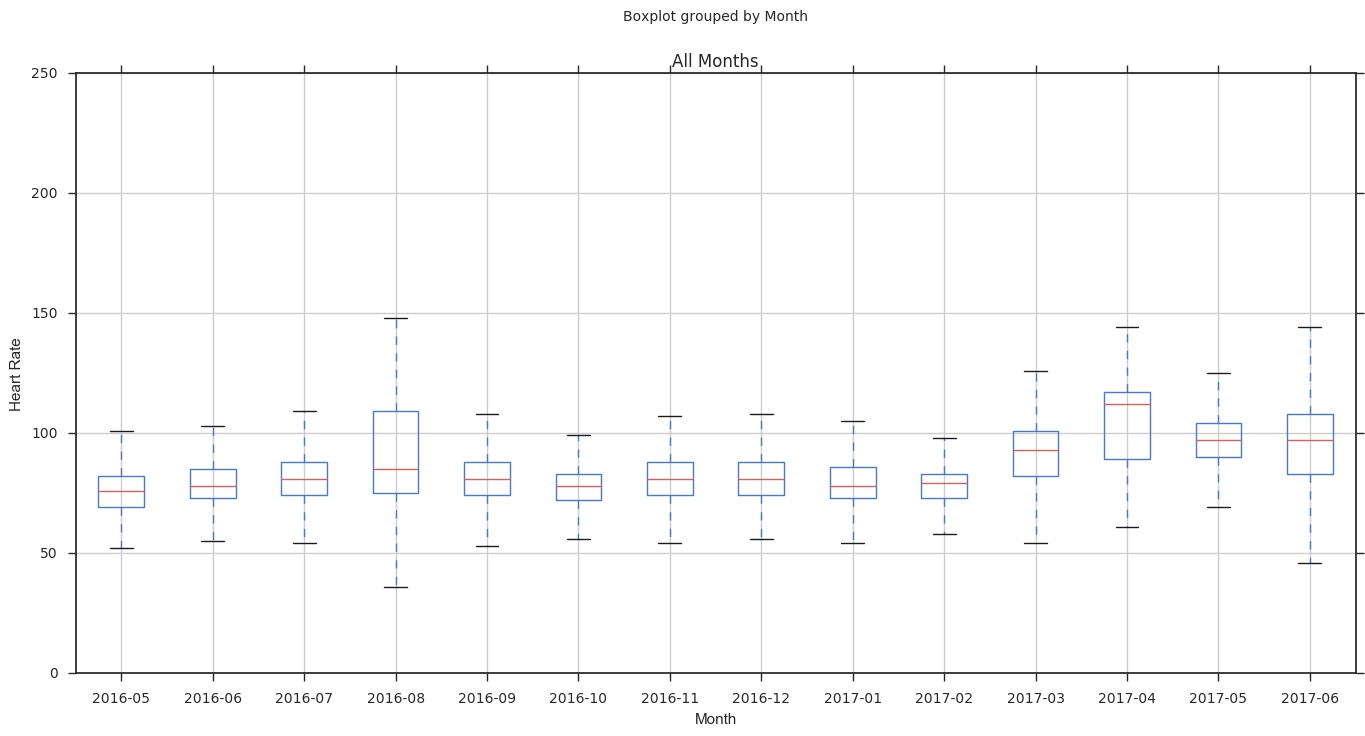

In [527]:
HR_df.boxplot(by='Month',column="HeartRate", return_type='axes')
plt.title('All Months')
plt.ylabel('Heart Rate')

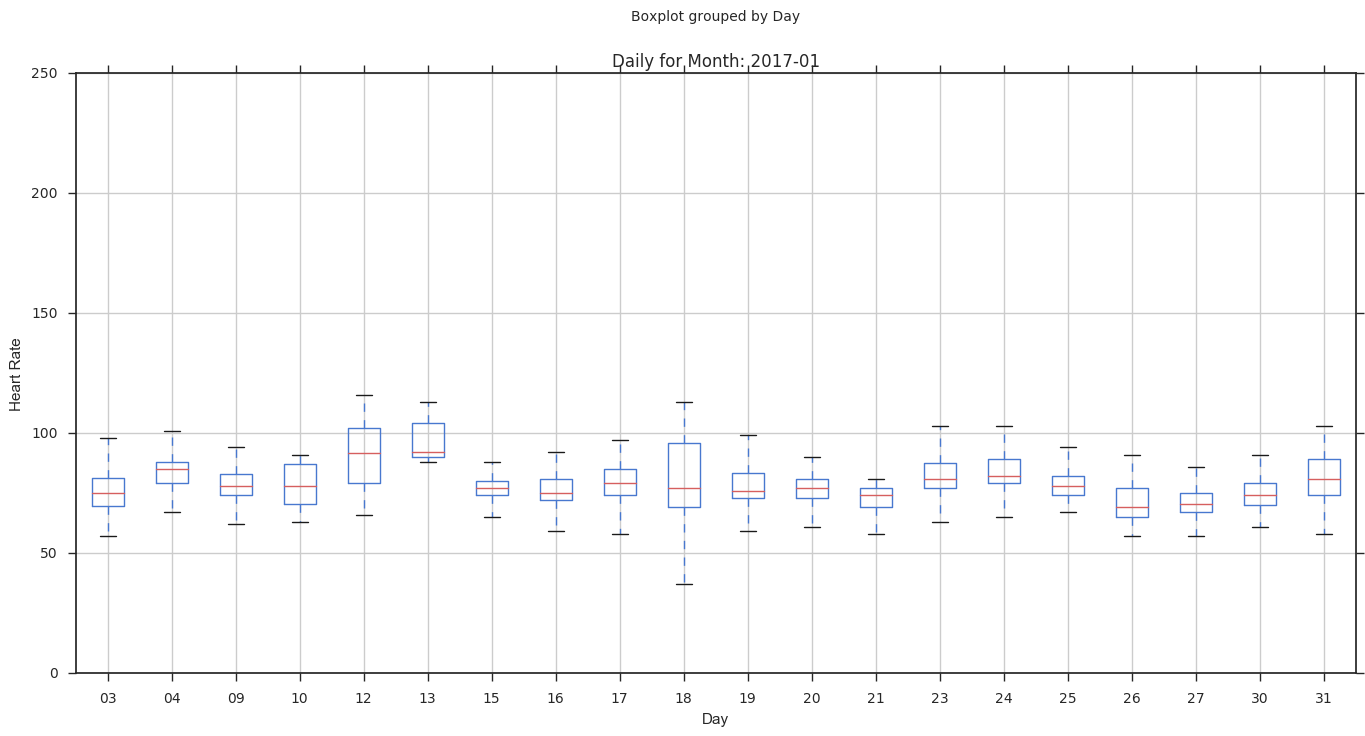

In [528]:
monthval = '2017-01' 
HR_df[HR_df['Month']==monthval].boxplot(by='Day',column="HeartRate", return_type='axes')
plt.title('Daily for Month: '+ monthval)
plt.ylabel('Heart Rate')

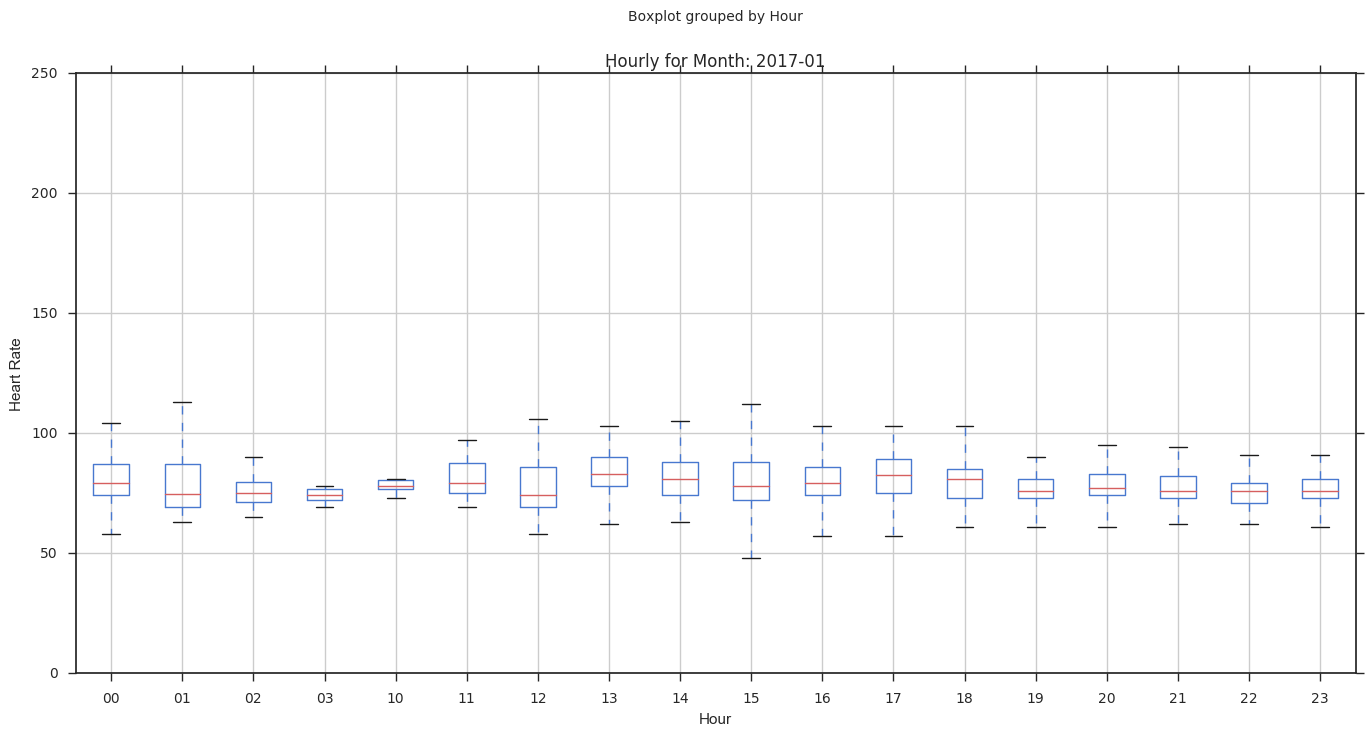

In [529]:
HR_df[HR_df['Month']==monthval].boxplot(by='Hour',column="HeartRate")
plt.title('Hourly for Month: '+ monthval)
plt.ylabel('Heart Rate')

### Flag Chemotherapy Days for specific analysis

The next two cells provide the ability to introduce cycles that start on specific days and include this data in the datasets so that they can be overlaid in graphics. In the example below, there are three cycles of 21 days. The getDelta function returns the cycle number when tpp == 0 and the days since day 0 when tpp == 2. This allows the overlaying of the cycles, with the days since day 0 being overlaid.

In [533]:
# This isnt efficient yet, just a first swipe. It functions as intended.
def getDelta(res,ttp,cyclelength):
    mz = [x if (x >= 0) & (x < cyclelength) else 999 for x in res]
    if ttp == 0:
        return(mz.index(min(mz))+1)
    else:
        return(mz[mz.index(min(mz))])

chemodays = np.array([date(2017,4,24),date(2017,5,16),date(2017,6,6)])

HR_df = xmltodf(e,"HKQuantityTypeIdentifierHeartRate","HeartRate")
#I dont think this is efficient yet...
a = HR_df['Create'].apply(lambda x: [x.days for x in x.date()-chemodays])
HR_df['ChemoCycle'] = a.apply(lambda x: getDelta(x,0,21))
HR_df['ChemoDays'] = a.apply(lambda x: getDelta(x,1,21))

Extracting HeartRate, type: HKQuantityTypeIdentifierHeartRate


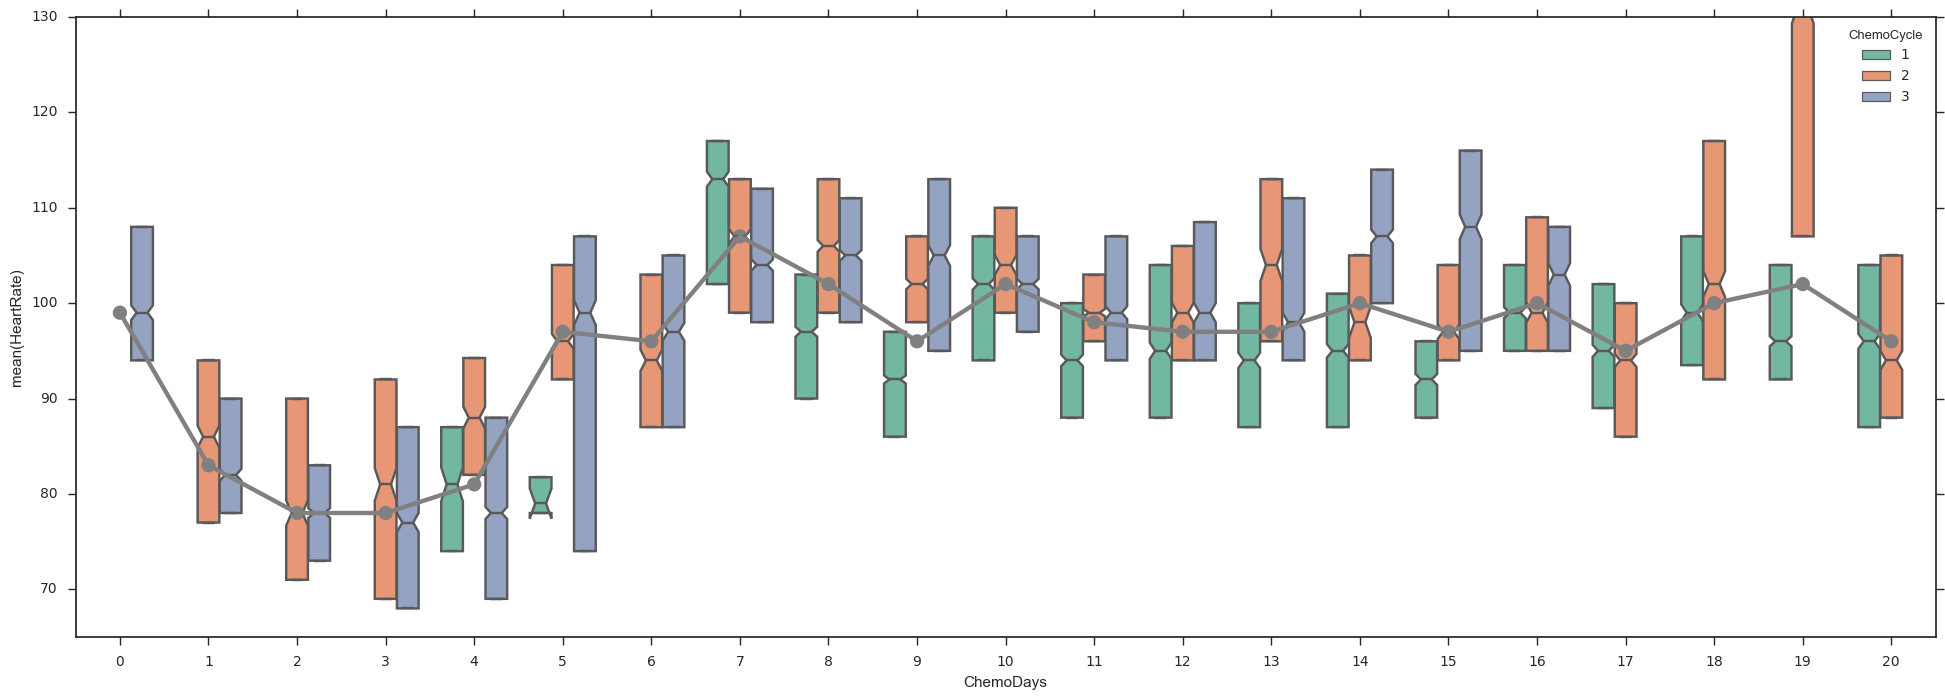

In [534]:
plotx = HR_df[HR_df['ChemoDays']<=21]
plt.rcParams['figure.figsize'] = 24, 8
ax = sns.boxplot(x="ChemoDays", y="HeartRate", hue="ChemoCycle", data=plotx, palette="Set2",notch=1,whis=0,width=0.75,showfliers=False)
plt.ylim(65,130)
#the next statement puts the chemodays variable as a rowname, we need to fix that
plotx_med = plotx.groupby('ChemoDays').median()
#this puts chemodays back as a column in the frame. I need to see if there is a way to prevent the effect
plotx_med.index.name = 'ChemoDays'
plotx_med.reset_index(inplace=True)

snsplot = sns.pointplot(x='ChemoDays', y="HeartRate", data=plotx_med,color='Gray')

## Boxplots Using Seaborn

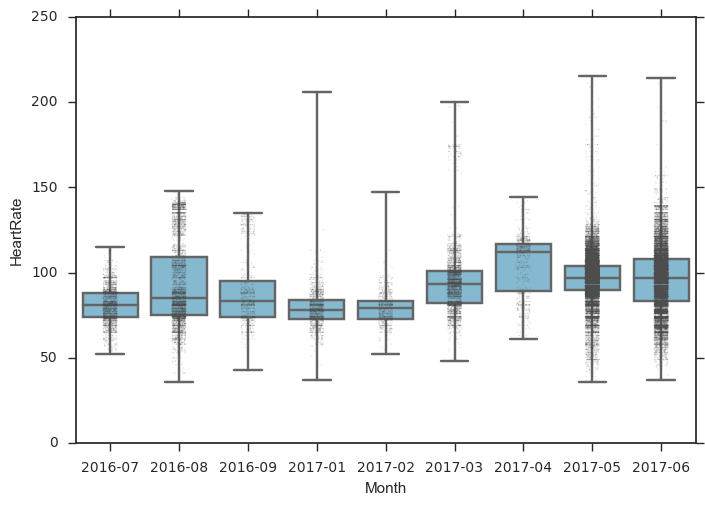

In [479]:

import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)

sns.boxplot(x="Month", y="HeartRate", data=HR_df,whis=np.inf, color="c")
# Add in points to show each observation
snsplot = sns.stripplot(x="Month", y="HeartRate", data=HR_df,jitter=True, size=1, alpha=.15, color=".3", linewidth=0)

# Go to Part 2 - Load the tables into CAS using SAS SWAT 
### Find Load AppleHeath Data Into CAS.ipynb